In [1]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import svm
from scipy import io
for data_name in ["mnist", "spam", "cifar10"]:
    data = io.loadmat("data/%s_data.mat" % data_name)
    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)


loaded mnist data!
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

loaded spam data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)

loaded cifar10 data!
test_data (10000, 3072)
training_data (50000, 3072)
training_labels (50000, 1)


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score # This is the only function you are allowed to use.
from scipy import io
import csv
import os
import argparse
import warnings
warnings.simplefilter('ignore')

def load_data(name):
    # Return the specified dataset by NAME
    return io.loadmat("data/%s_data.mat" % name)
mnist_data = load_data('mnist')
spam_data = load_data('spam')
cifar_data = load_data('cifar10')
all_data = [mnist_data, spam_data, cifar_data]

In [3]:
len(mnist_data['training_data'])

60000

In [4]:
#################################
# Question 1: Data Partitioning #
#################################
mnist_val_size = 10000
spam_val_size = round(spam_data['training_data'].shape[0]*0.2)
cifar_val_size = 5000
validation_sizes = [mnist_val_size, spam_val_size, cifar_val_size]

def partition(data, labels, validation_size):
    # output: training_data, training_label, validation_data, validation_label
    if data.shape[0] != labels.shape[0]:
        raise Exception("data size mismatch with label size!")
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data_shuffle = data[indices]
    labels_shuffle = labels[indices]
    return data_shuffle[validation_size:], labels_shuffle[validation_size:], data_shuffle[:validation_size], labels_shuffle[:validation_size]

In [ ]:
mnist_train = partition(mnist_data['training_data'], mnist_data['training_labels'], mnist_val_size)
mnist_train[2].shape

In [ ]:
#################################
# Question 2: SVMs              #
#################################

def train(X, Y, c = 1.0):
    # create, train, and return and SVM Model
    #clf = svm.LinearSVC(C=c)
    clf = svm.LinearSVC(C=c)
    clf.fit(X, Y)
    return clf

def num_examples_experiment(X_train, Y_train, X_val, Y_val, num_examples_arr, name):
    # train an svm for each number of examples.
    # Evaluate the training and validation performance
    # plot the results.
    train_acc = []
    val_acc = []
    for example in num_examples_arr:
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X = X_train[indices]
        Y = Y_train[indices]
        model = train(X[:example], Y[:example])
        train_acc.append(accuracy_score(Y_train, model.predict(X_train)))
        val_acc.append(accuracy_score(Y_val, model.predict(X_val)))
    plt.figure()
    plt.plot(num_examples_arr, train_acc, label = 'train_accuracy')
    plt.plot(num_examples_arr, val_acc, label = 'validation_accuracy')
    plt.xlabel('number of example')
    plt.ylabel('model accuracy')
    plt.title(name)
    plt.show()
    return 

def main_q2():
    # Run all of the code for question 3.
    MNIST_NUM_EXAMPLES_ARR = [100, 200, 500, 1000, 2000, 5000, 10000]
    SPAM_NUM_EXAMPLES_ARR = [100, 200, 500, 1000, 2000, spam_data['training_data'].shape[0]] # Figure out the number of examples in the dataset or handle this case.
    CIFAR_NUM_EXAMPLES_ARR = [100, 200, 500, 1000, 2000, 5000]
        
    # YOUR CODE HERE
    all_examples = [MNIST_NUM_EXAMPLES_ARR, SPAM_NUM_EXAMPLES_ARR, CIFAR_NUM_EXAMPLES_ARR]
    all_names = ['MNIST Dataset','Spam Dataset', 'CIFAR10 Dataset']
    for i in range(3):
        dataset = all_data[i]
        data = partition(dataset['training_data'], dataset['training_labels'], validation_sizes[i])
        num_examples_experiment(data[0], data[1], data[2], data[3], all_examples[i], all_names[i])
    return

In [ ]:
main_q2()

In [ ]:
#################################
# Question 3: Hyperparameters   #
#################################

def hyperparameter_search(X_train, Y_train, X_val, Y_val, parameter_values):
    val_acc = []
    for param in parameter_values:
        model = train(X_train, Y_train, param)
        val_acc.append(accuracy_score(Y_val, model.predict(X_val)))
    
    return val_acc

def main_q3():
    #c_values = [0.0001, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 7.5, 10.0, 20.0, 50.0, 100]
    c_values = np.logspace(-9, 9, num=19)
    dataset = mnist_data
    size = 10000
    data = partition(dataset['training_data'], dataset['training_labels'], mnist_val_size)
    val_acc_1 = hyperparameter_search(data[0][:size], data[1][:size], data[2], data[3], c_values)
    c_val = c_values[np.argmax(val_acc_1)]
    
    new_c_values = np.logspace(np.log10(c_val)-1, np.log10(c_val)+1, num=10)
    data = partition(dataset['training_data'], dataset['training_labels'], mnist_val_size)
    val_acc_2 = hyperparameter_search(data[0][:size], data[1][:size], data[2], data[3], new_c_values)
    c_val = new_c_values[np.argmax(val_acc_2)]
    
    val_acc = np.append(val_acc_1, val_acc_2)
    params = np.append(c_values, new_c_values)
    
    plt.figure()
    plt.xscale('log')
    plt.scatter(params, val_acc)
    plt.xlabel('C values')
    plt.ylabel('validation accuracy')
    plt.title('parameter value VS validation accuracy')
    plt.show()
    print('highest c value is: ' + str(c_val) + ',with accuracy: ' + str(max(val_acc)))
    return 

In [ ]:
main_q3()

In [ ]:
#################################
# Question 4: KFold CrossValid  #
#################################

def k_fold_cross_validation(X_train, Y_train, k, parameter_values):
    val_acc = []
    for param in parameter_values:
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        x_shuffle = X_train[indices]
        y_shuffle = Y_train[indices]
        k_acc = []
        for i in range(k):
            start = int(np.floor(i*len(X_train)/k))
            end = int(np.floor((i+1)*len(X_train)/k))
            train_x = np.append(x_shuffle[:start], x_shuffle[end:], axis=0)
            train_y = np.append(y_shuffle[:start], y_shuffle[end:], axis=0)
            val_x = x_shuffle[start:end]
            val_y = y_shuffle[start:end]
            model = train(train_x, train_y, param)
            k_acc.append(accuracy_score(val_y, model.predict(val_x)))
        val_acc.append(np.mean(k_acc))
    
    return val_acc

def main_q4():
    c_values = np.logspace(-9, 9, num=19)
    dataset = spam_data
    val_acc_1 = k_fold_cross_validation(dataset['training_data'], dataset['training_labels'], 5, c_values)
    c_val = c_values[np.argmax(val_acc_1)]
    
    new_c_values = np.logspace(np.log10(c_val)-0.1, np.log10(c_val)+0.1, num=10)
    val_acc_2 = k_fold_cross_validation(dataset['training_data'], dataset['training_labels'], 5, new_c_values)
    c_val = new_c_values[np.argmax(val_acc_2)]
    
    val_acc = np.append(val_acc_1, val_acc_2)
    params = np.append(c_values, new_c_values)
    
    plt.figure()
    plt.xscale('log')
    plt.scatter(params, val_acc)
    plt.xlabel('C values')
    plt.ylabel('validation accuracy')
    plt.title('parameter value VS 5-fold-validation accuracy')
    plt.show()
    print('highest c value is: ' + str(c_val) + ',with 5-fold-accuracy: ' + str(max(val_acc)))
    return

In [ ]:
main_q4()

In [9]:
#################################
# Question 5: Kaggle            #
#################################

# For kaggle, do whatever you like!
def kaggle_train(X, Y, c = 1.0, kernel_name='linear'):
    # create, train, and return and SVM Model
    #clf = svm.LinearSVC(C=c)
    print("here we train")
    if kernel_name == 'linear':
        clf = svm.LinearSVC(C=c)
    else:
        clf = svm.SVC(kernel=kernel_name, C=c)
    clf.fit(X, Y)
    return clf

def no_k_fold(X_train, Y_train, parameter_values, kernel_name, size):
    data = partition(X_train, Y_train, size)
    val_acc = []
    for param in parameter_values:
        model = kaggle_train(data[0][:3000], data[1][:3000], param, kernel_name)
        val_acc.append(accuracy_score(data[3], model.predict(data[2])))
    return val_acc

def k_fold_param_tuning_with_kernel(X_train, Y_train, k, parameter_values, kernel_name):
    val_acc = []
    for param in parameter_values:
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        x_shuffle = X_train[indices]
        y_shuffle = Y_train[indices]
        k_acc = []
        for i in range(k):
            start = int(np.floor(i*len(X_train)/k))
            end = int(np.floor((i+1)*len(X_train)/k))
            train_x = np.append(x_shuffle[:start], x_shuffle[end:], axis=0)
            train_y = np.append(y_shuffle[:start], y_shuffle[end:], axis=0)
            val_x = x_shuffle[start:end]
            val_y = y_shuffle[start:end]
            model = kaggle_train(train_x, train_y, param, kernel_name)
            k_acc.append(accuracy_score(val_y, model.predict(val_x)))
        val_acc.append(np.mean(k_acc))
    
    return val_acc

def kaggle_predict(dataset, kernel_name, k_fold_or_not = False, size=None):
    c_values = np.logspace(-7, 3, num=11)
    if k_fold_or_not:
        val_acc_1 = k_fold_param_tuning_with_kernel(dataset['training_data'], dataset['training_labels'], 5, c_values, kernel_name)
    else:
        val_acc_1 = no_k_fold(dataset['training_data'], dataset['training_labels'], c_values, kernel_name, size)
    c_val = c_values[np.argmax(val_acc_1)]
    
    new_c_values = np.logspace(np.log10(c_val)-0.1, np.log10(c_val)+0.1, num=4)
    if k_fold_or_not:
        val_acc_2 = k_fold_param_tuning_with_kernel(dataset['training_data'], dataset['training_labels'], 5, new_c_values, kernel_name)
    else:
        val_acc_2 = no_k_fold(dataset['training_data'], dataset['training_labels'], new_c_values, kernel_name, size)
    c_val = new_c_values[np.argmax(val_acc_2)]
    
    val_acc = np.append(val_acc_1, val_acc_2)
    params = np.append(c_values, new_c_values)
    
    plt.figure()
    plt.xscale('log')
    plt.scatter(params, val_acc)
    plt.xlabel('C values')
    plt.ylabel('validation accuracy')
    plt.title('parameter value VS validation accuracy on kernel '+kernel_name)
    plt.show()
    print('highest c value is: ' + str(c_val) + ',with 5-fold-accuracy: ' + str(max(val_acc)))
    final_model = kaggle_train(dataset['training_data'], dataset['training_labels'], c_val, kernel_name)
    return final_model.predict(dataset['test_data'])

def q5_kaggle(name, kernel):
    sizes = {'mnist': 2000, 'spam':round(spam_data['training_data'].shape[0]*0.2), 'cifar':1500}
    size = sizes[name]
    if name == 'mnist':
        print('working on MNIST dataset...')
        prediction = kaggle_predict(mnist_data, kernel, False, size)
        print('finish MNIST dataset')
    elif name == 'spam':
        print('working on SPAM dataset...')
        prediction = kaggle_predict(spam_data, kernel,True)
        print('finish spam dataset')
    else:
        print('working on CIFAR dataset...')
        prediction = kaggle_predict(cifar_data, kernel, False, size)
        print('finish CIFAR dataset')
    return prediction

In [ ]:
spam_prediction = q5_kaggle('spam', 'linear')

In [7]:
import pandas as pd
import numpy as np

# Usage results_to_csv(clf.predict(X_test))
def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission.csv', index_label='Id')
    
#results_to_csv(spam_prediction)

working on MNIST dataset...
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train


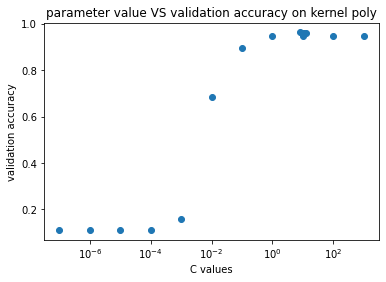

highest c value is: 7.943282347242816,with 5-fold-accuracy: 0.963
here we train
finish MNIST dataset


In [6]:
mnist_prediction = q5_kaggle('mnist', 'poly')

In [8]:
results_to_csv(mnist_prediction)

working on CIFAR dataset...
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train
here we train


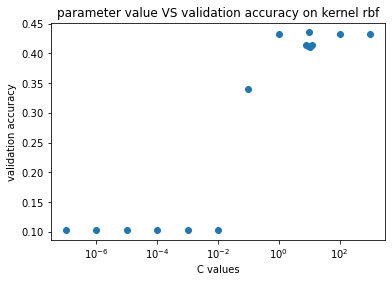

highest c value is: 7.943282347242816,with 5-fold-accuracy: 0.43533333333333335
here we train


In [ ]:
cifar_prediction = q5_kaggle('cifar', 'rbf')

In [11]:
results_to_csv(cifar_prediction)